In [1]:
import pandas as pd

import seaborn as sns

import matplotlib.pyplot as plt

from ukbb_recessive.regression.regressions import read_results_excel
import ukbb_recessive.regression.plotting as plotting


sns.set_style("whitegrid")

import matplotlib

from matplotlib import font_manager
import numpy as np
from matplotlib.cm import get_cmap

import glob

import matplotlib.ticker as ticker


# Add fonts
plotting.add_fonts(['../../../data/fonts'])
plotting.configure_matplotlib()

PLOTS_OUTPUT_DIR = '../../../data/plots/extended_figures'

tables_folder = '../../../data/tables'

Added: .../ukbb_recessive/data/fonts/Arimo-VariableFont_wght.ttf


# Extended figure 1 (Frequency distribution of PLPs)

In [2]:
def hets_freq_bin(hets_freq):
    if hets_freq <= 0:
        return '0%'
    elif hets_freq <= 0.5:
        return '0-0.5%'
    elif hets_freq <= 1:
        return '0.5-1%'
    elif hets_freq <= 2:
        return '1-2%'
    elif hets_freq <= 5:
        return '2-5%'
    else:
        return '>5%'

# samples of interest: European & non-related
european_non_rel_samples =  ".../450k/samples/european_non_related_no_withdrawal_to_include_450k.no_hom_comp_het.txt"

european_non_rel_samples = set(pd.read_csv(european_non_rel_samples, header=None)[0].values.tolist())
print ("Number of samples:", len(european_non_rel_samples))

# gene panel
gene_panel = pd.read_csv(".../450k/regions/gene-panel-gencode-v34.txt", header=None)
gene_panel.columns = ['gene', 'panel']


Number of samples: 376608


In [3]:
# read list of PLPs
plps = ".../450k/plp_selection/basic/new_gene_names/new_freq/new_relatedness/all_chr_total_presumable_plps_HFE_final_sorted.txt"
plps = pd.read_csv(plps, sep='\t')

# define hets frequency bins
plps['hets_freq'] = plps['hets']*100./len(european_non_rel_samples)
plps['hets_freq_bin'] = plps['hets_freq'].apply(hets_freq_bin)

# count number of variants per frequency bin
plps_freq_count = plps.groupby('hets_freq_bin').count()[['chr']].reset_index().rename(columns={'chr': 'plp_cnt'})

In [4]:
# count number of het carriers per gene and add gene panel information
plps_gene = plps.groupby('gene').agg({'hets': 'sum', 'homs':'sum'}).reset_index().merge(gene_panel, how='left').fillna(0)

# define hets frequency bins
plps_gene['hets_freq'] = plps_gene['hets']*100./len(european_non_rel_samples)
plps_gene['hets_freq_bin'] = plps_gene['hets_freq'].apply(hets_freq_bin)

# count number of genes per frequency bin
plps_freq_gene_count = plps_gene.groupby('hets_freq_bin').count()[['gene']].reset_index().rename(columns={'gene': 'plp_cnt'})
plps_freq_gene_count['plp_cnt'] = plps_freq_gene_count['plp_cnt'].astype(int)


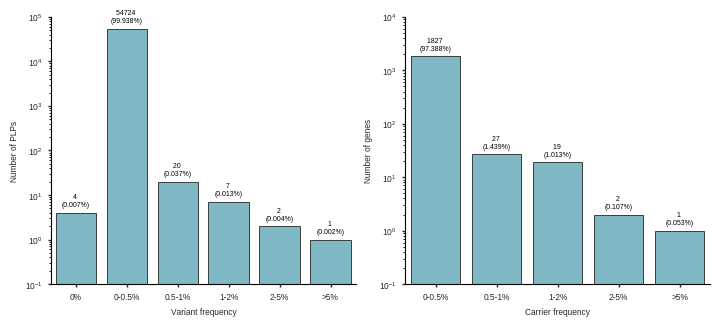

In [5]:
def plot_frequency_annotated(plps, ax):
    sns.barplot(data=plps, x='hets_freq_bin', y='plp_cnt', ax=ax, color='#74C0D1', edgecolor='k', linewidth=0.5)

    # add the annotation
    labels =[x.get_height() for x in ax.containers[-1]]
    labels_percentage = [f"{int(num)} \n({round(num*100/sum(labels), 3)}%)" for num in labels]

    ax.bar_label(ax.containers[-1],  labels=labels_percentage, label_type='edge', size=plotting.SMALL_SIZE, padding=3, color='k')


cm = 1/2.54  # centimeters in inches
k = 1.

fig = plt.figure(constrained_layout=True, figsize=(18*cm*k, 8*cm*k))

axes = fig.subplots(1, 2)

# plot variant frequency distribution
ax = axes[0]

plot_frequency_annotated(plps_freq_count, ax)

plotting.configure_axis(ax, x_label="Variant frequency", y_label="Number of PLPs", ylim=(0.1, 100000))
ax.set_yscale("log")

# plot gene frequency distribution
ax = axes[1]

plot_frequency_annotated(plps_freq_gene_count, ax)

plotting.configure_axis(ax, x_label="Carrier frequency", y_label="Number of genes", ylim=(0.1, 10000))
ax.set_yscale("log")


plt.savefig(f"{PLOTS_OUTPUT_DIR}/ext_figure_1.pdf", format="pdf", bbox_inches="tight")


# Extended figure 2 (Childlessness for other s-het sources)

In [8]:
tables_folder = '../../../data/tables'
output_folder = '../../../data/plots'
all_s_hets =['Roulette', 'Weghorn', 'Cassa', 'pLI']

results_path = f"{tables_folder}/table_selection_analysis.xlsx"

# load flat table
childlessness = read_results_excel(results_path, flatten_multiindex=True)

# leave only necessary s_het effect
childlessness = childlessness[childlessness['feature'].str.contains("s_het")]

# add odds ratio distance
childlessness = plotting.add_odds_ratio_intervals(childlessness)

In [9]:
# Dictionary to rename target columns
renaming_dict_target = {
    'is_blond': 'Hair color', 
    'childlessness': 'Childlessness'
}

# select targets of interest
childlessness = childlessness[childlessness['target'].isin(renaming_dict_target.keys())].copy()
childlessness['target'] = childlessness['target'].apply(lambda x: renaming_dict_target.get(x, x))

# select gender of interest
childlessness = childlessness[childlessness['gender'] == 'all']

# select analyses
renaming_dict_analyses = {
    'selection regressions on [s_het_recessive_all]' : 'PLPs in recessive genes',
    'selection regressions on [s_het_lof_without_AR]' : 'Singleton LoFs in non-recessive genes',
    'exlude_lof_carriers regressions on [s_het_recessive_all]' : 'PLPs in recessive genes w/out LoF carriers'
}

childlessness = childlessness[childlessness['analysis'].isin(renaming_dict_analyses.keys())].copy()
childlessness['analysis'] = childlessness['analysis'].apply(lambda x: renaming_dict_analyses.get(x, x))

childlessness.head(3)

dataset              feature    effect  odds_ratio  odds_ratio_lower  \
24    Cassa  s_het_recessive_all  0.693995    2.001696          1.161002   
25      pLI  s_het_recessive_all  0.127739    1.136257          1.036840   
26  Weghorn  s_het_recessive_all  0.605141    1.831510          1.166799   

    odds_ratio_upper odds_ratio_pretty   p_value  p_value_corrected  \
24          3.451148        OR = 2.002  0.001032           0.010316   
25          1.245206        OR = 1.136  0.000326           0.003262   
26          2.874898        OR = 1.832  0.000546           0.005460   

    bonferroni_correction_coef  n_observations         target gender  \
24                          10          353246  Childlessness    all   
25                          10          337479  Childlessness    all   
26                          10          353425  Childlessness    all   

                   analysis  \
24  PLPs in recessive genes   
25  PLPs in recessive genes   
26  PLPs in recessive genes   

                                              formula    family  \
24  childlessness ~ s_het_recessive_all + age_at_r...  binomial   
25  childlessness ~ s_het_recessive_all + age_at_r...  binomial   
26  childlessness ~ s_het_recessive_all + age_at_r...  binomial   

   p_value_pretty p_value_corrected_pretty  odds_ratio_lower_distance  \
24      1.03×10⁻³                     0.01                   0.840695   
25      3.26×10⁻⁴                3.26×10⁻³                   0.099417   
26      5.46×10⁻⁴                5.46×10⁻³                   0.664711   

    odds_ratio_upper_distance  
24                   1.449451  
25                   0.108950  
26                   1.043388

In [10]:
def plot_3_ext(ax, s_het_tag, text_pos):

    y_order = ['Childlessness', 'Hair color']
    group_order = ['Singleton LoFs in non-recessive genes', 'PLPs in recessive genes w/out LoF carriers', 'PLPs in recessive genes'][::-1]

    legend_kwargs = {
        "bbox_to_anchor": (0.0, 1., 1, .102), 
        "frameon": False,
        "mode": "expand", 
        "ncol": 1, 
        "labelspacing": 0.1, 
        "markerfirst": False, 
        'fontsize': plotting.MEDIUM_SIZE
    }

    # colors=['#B048B5', '#046307', '#FFAE42']
    colors=['#B048B5',  '#FF8225', '#046307',]

    plotted_data = plotting.plot_errorbar_grouped(df=childlessness[childlessness['dataset'] == s_het_tag].copy(), 
                                        axis=ax, y_column='target', group_column = 'analysis',  
                                        legend_loc='upper left', 
                                        legend_kwargs=legend_kwargs,
                                        group_scale=0.02, 
                                        y_scale=0.08,
                                        colors=colors,
                                        y_order=y_order, 
                                        group_order=group_order
                                        )


    plotting.configure_axis(ax, x_label='OR (99% CI)', y_label=None, format_x=True, ymargin=0.12,)

    # Display p-values or any other information in the sidebar
    p_values = plotted_data['p_value_corrected_pretty']
    or_values = plotted_data['odds_ratio']
    positions = plotted_data['y']


    for i, (p, oddsr, pos) in enumerate(zip(p_values, or_values, positions)):
        ax.text(text_pos, pos+0.01, f'{oddsr:.2f}   {p}', va='center', size=plotting.MEDIUM_SIZE)


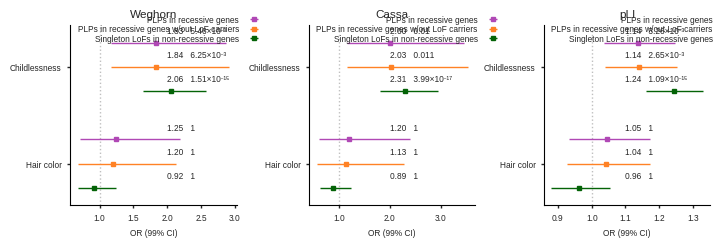

In [11]:
cm = 1/2.54  # centimeters in inches
k = 1.

fig = plt.figure(constrained_layout=True, figsize=(18*cm*k, 6*cm*k))

axes = fig.subplots(1, 3)

plot_3_ext(axes[0], 'Weghorn', text_pos=2)
axes[0].set_title('Weghorn')

plot_3_ext(axes[1], 'Cassa', text_pos=2)
axes[1].set_title('Cassa')

plot_3_ext(axes[2], 'pLI', text_pos=1.1)
axes[2].set_title('pLI')


plt.savefig(f"{PLOTS_OUTPUT_DIR}/ext_figure_2.pdf", format="pdf", bbox_inches="tight")

# Extended figure 3 (PLPs count, s-het burden distribution for childlessness)

In [ ]:
datasets_path = '.../450k/datasets'

# samples of interest: European & non-related without hom and comp_het
european_non_rel_samples = (
    ".../450k/samples/european_non_related_no_withdrawal_to_include_450k.no_hom_comp_het.txt"
)

with open(european_non_rel_samples, 'r') as f:
    european_non_rel_samples = [l.strip() for l in f.readlines()]


dataset = pd.read_csv(f"{datasets_path}/Roulette.csv", sep='\t')
dataset = dataset[dataset['eid'].astype(str).isin(european_non_rel_samples)].copy()

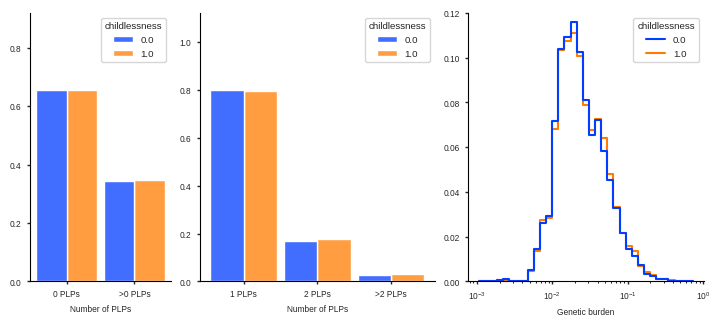

In [ ]:
import matplotlib.ticker as ticker


cm = 1/2.54  # centimeters in inches
k = 1.

fig = plt.figure(constrained_layout=True, figsize=(18*cm*k, 8*cm*k))

axes = fig.subplots(1, 3, width_ratios=[0.6, 1, 1])

# plot % of zeros 
dataset['mutations_cnt_recessive_all_label'] = dataset['mutations_cnt_recessive_all'].apply(lambda x: f"{int(x)} PLPs" if x <= 0 else ">0 PLPs")
sns.histplot(data=dataset.sort_values('mutations_cnt_recessive_all'), 
             x='mutations_cnt_recessive_all_label', hue='childlessness', 
             multiple='dodge', palette='bright', shrink=0.9,
             ax=axes[0], stat='probability', 
             common_norm=False, cumulative=False,
             log_scale=False, fill=True)

plotting.configure_axis(axes[0], x_label="Number of PLPs")

# plot PLPs count
dataset['mutations_cnt_recessive_all_label'] = dataset['mutations_cnt_recessive_all'].apply(lambda x: f"{int(x)} PLPs" if x <= 2 else ">2 PLPs")
sns.histplot(data=dataset[dataset['s_het_recessive_all'] > 0].sort_values('mutations_cnt_recessive_all'), 
             x='mutations_cnt_recessive_all_label', hue='childlessness', 
             multiple='dodge', palette='bright', shrink=0.9,
             ax=axes[1], stat='probability', 
             common_norm=False, cumulative=False,
             log_scale=False, fill=True)

plotting.configure_axis(axes[1], x_label="Number of PLPs")

# plot s-het burden
sns.histplot(data=dataset, 
             x='s_het_recessive_all', hue='childlessness', 
             ax=axes[2], palette='bright', stat='probability', 
             common_norm=False, cumulative=False, bins=35,
             log_scale=True, element="step", fill=False,)

plotting.configure_axis(axes[2], x_label="Genetic burden", ylim=(0, 0.12))

plt.savefig(f"{PLOTS_OUTPUT_DIR}/ext_figure_3.pdf", format="pdf", bbox_inches="tight")

# Extended figure 4 (cohort downsamling)

In [ ]:
tables_folder = '../../../data/tables'

recessive_df = read_results_excel(f"{tables_folder}/sampling/dataset/table_dataset_sampling_regressions_on_[s_het_recessive_all].xlsx", 
                                  flatten_multiindex=True)
recessive_df['dataset'] = 'PLPs in recessive genes'

lof_df = read_results_excel(f"{tables_folder}/sampling/dataset/table_dataset_sampling_regressions_on_[s_het_lof_without_AR].xlsx", 
                            flatten_multiindex=True)
lof_df['dataset'] = 'Singleton LoFs in non-recessive highly constrained genes'

data = pd.concat([recessive_df, lof_df])

# leave only necessary s_het effect
data = data[data['feature'].str.contains("s_het")]

# add odds ratio distance
data = plotting.add_odds_ratio_intervals(data)
data = plotting.add_effect_size_intervals(data)
data['sample_size'] = (data['analysis'].str.split('=', expand=True)[1].astype(float)*len(european_non_rel_samples)).astype(int)
data['p_value_corrected'] = (data['p_value'] * 10).apply(lambda x: 1 if x > 1 else x)

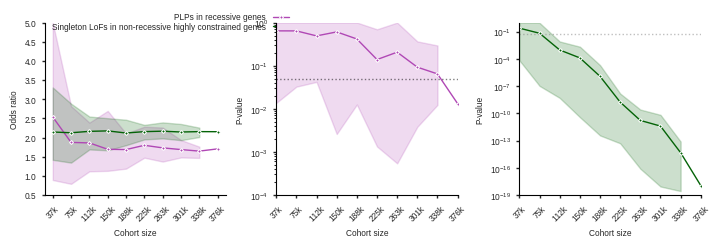

In [ ]:
cm = 1/2.54  # centimeters in inches
k = 1.

fig = plt.figure(constrained_layout=True, figsize=(18*cm*k, 6*cm*k))

ticks = data['sample_size'].unique()
tick_labels = [f"{int(x/1000)}k" for x in ticks]

axes = fig.subplots(1, 3)

colors=['#B048B5',  '#046307',]

# plot odd ratios
sns.lineplot(data=data, x='sample_size', y='odds_ratio', palette=colors,
             marker="D", hue='dataset', errorbar=('pi', 99), 
             linewidth=1, markersize=2, ax=axes[0])

plotting.configure_axis(axes[0], x_label='Cohort size', y_label='Odds ratio', ylim=(0.5,5))

axes[0].set_xticks(ticks)
axes[0].set_xticklabels(ticks)
axes[0].set_xticklabels(tick_labels, rotation=45)
axes[0].legend(loc='upper left', bbox_to_anchor=(0.0, 1., 1, .102), frameon=False, 
               mode="expand", ncol=1, labelspacing=0.1, markerfirst=False, fontsize=plotting.MEDIUM_SIZE)

# plot PLP in recessive genes

sns.lineplot(data=data[data['dataset'].str.contains('PLP')], x='sample_size', y='p_value_corrected', 
             marker="D", errorbar=('pi', 99), 
             linewidth=1, markersize=2, ax=axes[1], legend=None, color='#B048B5')

axes[1].axhline(y=0.05, color='k', linestyle='dotted', linewidth=1, alpha=0.5)

axes[1].set_yscale('log')

plotting.configure_axis(axes[1], x_label='Cohort size', y_label='P-value', ylim = (0.0001, 1), xlim=[ticks[0], ticks[-1]])
axes[1].set_xticks(ticks)
axes[1].set_xticklabels(tick_labels, rotation=45)

# plot LoFs in recessive genes

sns.lineplot(data=data[data['dataset'].str.contains('LoF')], x='sample_size', y='p_value_corrected', 
             marker="D", errorbar=('pi', 99), 
             linewidth=1, markersize=2, ax=axes[2], legend=None, color='#046307')

axes[2].axhline(y=0.05, color='gray', linestyle='dotted', linewidth=1, alpha=0.5)

axes[2].set_yscale('log')

plotting.configure_axis(axes[2], x_label='Cohort size', y_label='P-value', ylim = (1e-19, 1), xlim=[ticks[0], ticks[-1]])
axes[2].set_xticks(ticks)
axes[2].set_xticklabels(tick_labels, rotation=45)

plt.savefig(f"{PLOTS_OUTPUT_DIR}/ext_figure_4.pdf", format="pdf", bbox_inches="tight")

# Extended figure 5 (other phenotypes for other s-het sources)

In [12]:
tables_folder = '../../../data/tables'

results_path = f"{tables_folder}/table_phenotype_analysis.xlsx"

# load flat table
phenotypes = read_results_excel(results_path, flatten_multiindex=True)

# leave only necessary s_het effect
phenotypes = phenotypes[phenotypes['feature'].str.contains("s_het")]

# add odds ratio distance
phenotypes = plotting.add_odds_ratio_intervals(phenotypes)
phenotypes = plotting.add_effect_size_intervals(phenotypes)

In [13]:
# Dictionary to rename target columns
renaming_dict_target = {
    'is_blond': 'Hair color', 
    'years_of_edu': 'Years of\neducation',
    'diagnosis_total_ICD10_cnt_log': 'Diagnoses\ncount (log)',
    'ICD_infertility': 'Infertility',
    'living_with_a_partner': 'Has partner',
    'fluid_intelligence_score': 'Fluid\nintelligence',
    'childlessness': 'Childlessness'
}

# select targets of interest
phenotypes = phenotypes[phenotypes['target'].isin(renaming_dict_target.keys())].copy()
phenotypes['target'] = phenotypes['target'].apply(lambda x: renaming_dict_target.get(x, x))

# select gender of interest
phenotypes = phenotypes[phenotypes['gender'] == 'all']

# select analyses
renaming_dict_analyses = {
    'phenotype regressions on [s_het_recessive_all]' : 'PLPs in recessive genes',
    'phenotype regressions on [s_het_lof_without_AR]' : 'Singleton LoFs in non-recessive genes'
}

phenotypes = phenotypes[phenotypes['analysis'].isin(renaming_dict_analyses.keys())].copy()
phenotypes['analysis'] = phenotypes['analysis'].apply(lambda x: renaming_dict_analyses.get(x, x))

phenotypes.head(3)

dataset              feature    effect  odds_ratio  odds_ratio_lower  \
0    Cassa  s_het_recessive_all  0.693995    2.001696          1.161002   
1      pLI  s_het_recessive_all  0.127739    1.136257          1.036840   
2  Weghorn  s_het_recessive_all  0.605141    1.831510          1.166799   

   odds_ratio_upper odds_ratio_pretty   p_value  p_value_corrected  \
0          3.451148        OR = 2.002  0.001032           0.010316   
1          1.245206        OR = 1.136  0.000326           0.003262   
2          2.874898        OR = 1.832  0.000546           0.005460   

   bonferroni_correction_coef  ...  gender                 analysis  \
0                          10  ...     all  PLPs in recessive genes   
1                          10  ...     all  PLPs in recessive genes   
2                          10  ...     all  PLPs in recessive genes   

                                             formula    family p_value_pretty  \
0  childlessness ~ s_het_recessive_all + age_at_r...  binomial      1.03×10⁻³   
1  childlessness ~ s_het_recessive_all + age_at_r...  binomial      3.26×10⁻⁴   
2  childlessness ~ s_het_recessive_all + age_at_r...  binomial      5.46×10⁻⁴   

  p_value_corrected_pretty odds_ratio_lower_distance  \
0                     0.01                  0.840695   
1                3.26×10⁻³                  0.099417   
2                5.46×10⁻³                  0.664711   

  odds_ratio_upper_distance  effect_lower_distance  effect_upper_distance  
0                  1.449451               0.544712               0.544712  
1                  0.108950               0.091562               0.091562  
2                  1.043388               0.450877               0.450877  

[3 rows x 22 columns]

In [14]:
def format_thousands(x):
    return f'{x:,.0f}'  # Use , as a thousand separator and format as integers

def plot_phenotype(ax, y_order, dataset, plot_entity='odds_ratio', legend_loc='upper left'):

    group_order = ['Singleton LoFs in non-recessive genes', 'PLPs in recessive genes'][::-1]

    legend_kwargs = {
        "bbox_to_anchor": (0.0, 1., 1, .102), 
        "frameon": False,
        "mode": "expand", 
        "ncol": 1, 
        "labelspacing": 0.1, 
        "markerfirst": False, 
        'fontsize': plotting.MEDIUM_SIZE
    }

    colors=['#B048B5', '#046307',]

    vline_loc = 1 if plot_entity == 'odds_ratio' else 0

    plotted_data = plotting.plot_errorbar_grouped(df=phenotypes[phenotypes['target'].isin(y_order) & (phenotypes['dataset'] == dataset)].copy(), 
                                        axis=ax, y_column='target', group_column = 'analysis',  
                                        legend_loc=legend_loc, 
                                        legend_kwargs=legend_kwargs,
                                        group_scale=0.03, 
                                        y_scale=0.1,
                                        colors=colors,
                                        y_order=y_order, 
                                        group_order=group_order, 
                                        plot_entity=plot_entity, 
                                        vertical_loc=vline_loc, 
                                        horizontal=False)


    # plotting.configure_axis(ax, x_label='Odds ratio (99% CI)', y_label=None, ymargin=0.12)

    # Display p-values or any other information in the sidebar
    p_values = plotted_data['p_value_corrected_pretty']
    or_values = plotted_data[plot_entity] 
    positions = plotted_data['y']

    plot_loc = plotted_data[f'{plot_entity}'] - plotted_data[f'{plot_entity}_lower_distance']

    for i, (loc, p, oddsr, pos) in enumerate(zip(plot_loc, p_values, or_values, positions)):
        ax.text(loc, pos+0.005, f'{round(oddsr, 2)}   {p}', va='center', size=plotting.MEDIUM_SIZE)


ticks_config = {
    'Weghorn': [
            [-3, -2, -1, 0], 
            [-1.5, -1.0, -0.5, 0.0],
            [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
        ], 

    'Cassa': [
            [-3, -2, -1, 0], 
            [-2.0, -1.5, -1.0, -0.5, 0.0],
            [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
        ], 

    'pLI': [
            [ -1, -0.8, -0.6, -0.4, -0.2, 0], 
            [-0.5, -0.4, -0.3, -0.2, -0.1, 0.0],
            [0.0, 0.05, 0.1, 0.15, 0.2]
        ], 
}

xlim_config = {
    'Weghorn': [(-3.2, 0.2), (-1.6, 0.1), (-0.08, 0.55)],
    'Cassa': [None, (-2, 0.1), (-0.01, 0.6)],
    'pLI': [(-1, 0.1), (-0.56, 0.056), (-0.01, 0.2)]
}

def plot_phenotypes(subfig, dataset):
    ticks = ticks_config[dataset]
    xlim = xlim_config[dataset]

    # plot phenotypes results
    ax_left = subfig.subplots(3, 1)

    # years of education
    plot_phenotype(ax_left[0], y_order=['Years of\neducation'], plot_entity='effect', legend_loc=None, dataset=dataset)
    plotting.configure_axis(ax_left[0], xlim=xlim[0], x_label='Effect size',  ymargin=1, format_x=True)
    ax_left[0].set_xticks(ticks[0])
    ax_left[0].set_xticklabels(ticks[0])

    # fluid intelligence
    plot_phenotype(ax_left[1], y_order=['Fluid\nintelligence'], plot_entity='effect',legend_loc=None, dataset=dataset)
    plotting.configure_axis(ax_left[1], xlim=xlim[1], x_label='Effect size',  ymargin=1, format_x=True)
    ax_left[1].set_xticks(ticks[1])
    ax_left[1].set_xticklabels(ticks[1])

    # diagnoses count
    plot_phenotype(ax_left[2], y_order=['Diagnoses\ncount (log)'], plot_entity='effect', legend_loc=None, dataset=dataset)
    plotting.configure_axis(ax_left[2], xlim=xlim[2], x_label='Effect size',  ymargin=1, format_x=True)
    ax_left[2].set_xticks(ticks[2])
    ax_left[2].set_xticklabels(ticks[2])

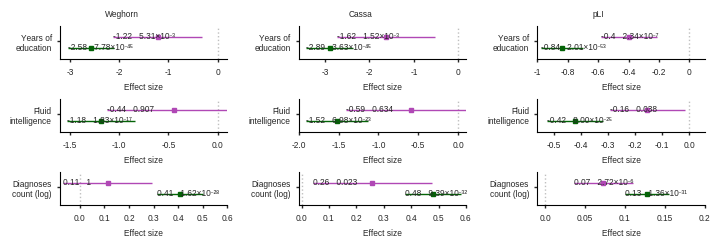

In [15]:
cm = 1/2.54  # centimeters in inches
k = 1.
fig = plt.figure(constrained_layout=True, figsize=(18*cm*k, 6*cm*k))

# divide subfigure into left and right parts
subfigs = fig.subfigures(nrows=1, ncols=3, width_ratios=[1, 1, 1], wspace=0.03)

plot_phenotypes(subfigs[0], 'Weghorn')
subfigs[0].suptitle('Weghorn', fontsize=plotting.MEDIUM_SIZE)

plot_phenotypes(subfigs[1], 'Cassa')
subfigs[1].suptitle('Cassa', fontsize=plotting.MEDIUM_SIZE)

plot_phenotypes(subfigs[2], 'pLI')
subfigs[2].suptitle('pLI', fontsize=plotting.MEDIUM_SIZE)

plt.savefig(f"{PLOTS_OUTPUT_DIR}/ext_figure_5.pdf", format="pdf", bbox_inches="tight")

# Extended figure 6 (covariates analysis)

In [ ]:
def parse_covariate(analysis):
    if len(analysis.split(',')) > 2:
        return 'With all covariates'
    elif 'years_of_edu' in analysis:
        return 'With years of education'
    elif 'diagnosis_total_ICD10_cnt_log' in analysis:
        return 'With diagnoses count (log)'
    elif 'ICD_infertility' in analysis:
        return 'With infertility status'
    elif 'living_with_a_partner' in analysis:
        return 'With partner status'
    elif 'fluid_intelligence_score' in analysis:
        return 'With fluid intelligence'
    else:
        return 'Original regression'

In [ ]:
results_path = f"{tables_folder}/table_covariate_analysis.xlsx"

# load flat table
covariates = read_results_excel(results_path, flatten_multiindex=True)

# leave only necessary s_het effect and dataset
covariates = covariates[covariates['feature'].str.contains("s_het")]
covariates = covariates[covariates['dataset'] == 'Roulette']
covariates = covariates[covariates['target'] == 'childlessness']
covariates = covariates[~covariates['analysis'].str.contains('years_of_edu|fluid_intelligence_score')]

# add odds ratio distance
covariates = plotting.add_odds_ratio_intervals(covariates)
covariates = plotting.add_effect_size_intervals(covariates)

# parse covariates
covariates['covariate'] = covariates['analysis'].apply(parse_covariate)


In [ ]:
def plot_covariates(ax, text_pos=2.5, plot_data=covariates):
    y_order = ['childlessness', 'is_blond']
    # group_order = ['Original regression',  'With years of education', 'With fluid intelligence', 
    #                'With diagnoses count (log)', 'With infertility status', 
    #                'With partner status', 'With all covariates']

    group_order = ['Original regression',  
                   'With diagnoses count (log)', 'With infertility status', 
                   'With partner status']
    
    legend_kwargs = {
        "bbox_to_anchor": (0.0, 1.5, 1, .102), 
        "frameon": False,
        "mode": "expand", 
        "ncol": 2, 
        "labelspacing": 0.1, 
        "markerfirst": False, 
        'fontsize': plotting.MEDIUM_SIZE
    }


    plotted_data = plotting.plot_errorbar_grouped(df=plot_data, 
                                        axis=ax, y_column='target', group_column = 'covariate',  
                                        legend_loc='upper left', 
                                        legend_kwargs=legend_kwargs,
                                        group_scale=0.01, 
                                        y_scale=0.13,
                                        # colors=colors,
                                        y_order=y_order, 
                                        group_order=group_order)


    plotting.configure_axis(ax, x_label='OR (99% CI)', y_label=None)

    # Display p-values or any other information in the sidebar
    p_values = plotted_data['p_value_corrected_pretty']
    or_values = plotted_data['odds_ratio']
    positions = plotted_data['y']

    for i, (p, oddsr, pos) in enumerate(zip(p_values, or_values, positions)):
        ax.text(oddsr+0.1, pos+0.001, f'{oddsr:.2f}   {p}', va='center', size=plotting.MEDIUM_SIZE)

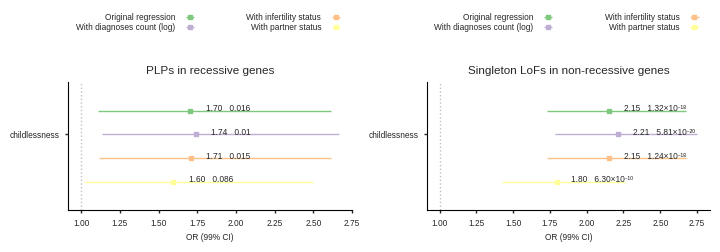

In [ ]:
cm = 1/2.54  # centimeters in inches
k = 1.

fig = plt.figure(constrained_layout=True, figsize=(18*cm*k, 6*cm*k))

axes = fig.subplots(1, 2)

plot_covariates(axes[0], text_pos=2.5, plot_data=covariates[covariates['feature'] == 's_het_recessive_all'].copy())
axes[0].set_title('PLPs in recessive genes')

plot_covariates(axes[1], text_pos=2.5, plot_data=covariates[covariates['feature'] == 's_het_lof_without_AR'].copy())
axes[1].set_title('Singleton LoFs in non-recessive genes')

plt.savefig(f"{PLOTS_OUTPUT_DIR}/ext_figure_6.pdf", format="pdf", bbox_inches="tight")

# Extended figure 7 (deprivation analysis)

In [ ]:
def parse_covariate(analysis):
    if 'multiple_deprivation_engand' in analysis:
        return 'With multiple deprivation'
    elif 'edu_deprivation_england' in analysis:
        return 'With educational deprivation'
    elif 'housing_deprivation_england' in analysis:
        return 'With housing deprivation'
    elif 'income_deprivation_england' in analysis:
        return 'With income deprivation'
    elif 'health_deprivation_england' in analysis:
        return 'With health deprivation'
    else:
        return 'Original regression'
    
# Dictionary to rename target columns
renaming_dict_target = {
    'is_blond': 'Hair color', 
    'years_of_edu': 'Years of\neducation',
    'diagnosis_total_ICD10_cnt_log': 'Diagnoses\ncount (log)',
    'ICD_infertility': 'Infertility',
    'living_with_a_partner': 'Has partner',
    'fluid_intelligence_score': 'Fluid\nintelligence',
    'childlessness': 'Childlessness'
}

In [ ]:
results_path_1 = f"{tables_folder}/table_covariate_deprivation_analysis.xlsx"
results_path_2 = f"{tables_folder}/table_id_vs_rest_covariate_deprivation_analysis.xlsx"

# load flat table
deprivation = pd.concat([read_results_excel(results_path_1, flatten_multiindex=True), 
                         read_results_excel(results_path_2, flatten_multiindex=True)])

# leave only necessary s_het effect and dataset
deprivation = deprivation[deprivation['feature'].str.contains("s_het")]
deprivation = deprivation[deprivation['dataset'] == 'Roulette']
deprivation = deprivation[deprivation['target'] != 'is_blond']
deprivation['target'] = deprivation['target'].apply(lambda x: renaming_dict_target.get(x, x))


# add odds ratio distance
deprivation = plotting.add_odds_ratio_intervals(deprivation)
deprivation = plotting.add_effect_size_intervals(deprivation)

# parse covariates
deprivation['covariate'] = deprivation['analysis'].apply(parse_covariate)

# look only at recessive
deprivation = deprivation[deprivation['feature'] != 's_het_lof_without_AR'].copy()

In [ ]:
def plot_deprivation(ax, targets, plot_data=deprivation, legend_loc='upper left', plot_entity='odds_ratio'):
    plot_data=plot_data[plot_data['target'].isin(targets)].copy()

    y_order = targets
    group_order = ['Original regression',  'With educational deprivation', 'With health deprivation',
                   'With housing deprivation', 'With income deprivation', 'With multiple deprivation']
        
    legend_kwargs = {
        "bbox_to_anchor": (0.0, 1.5, 1, .102), 
        "frameon": False,
        "mode": "expand", 
        "ncol": 1, 
        "labelspacing": 0.1, 
        "markerfirst": False, 
        'fontsize': plotting.MEDIUM_SIZE
    }


    plotted_data = plotting.plot_errorbar_grouped(df=plot_data, 
                                        axis=ax, y_column='target', group_column = 'covariate',  
                                        legend_loc=legend_loc, 
                                        legend_kwargs=legend_kwargs,
                                        group_scale=0.01, 
                                        y_scale=0.13,
                                        plot_entity=plot_entity,
                                        vertical_loc=1 if plot_entity == 'odds_ratio' else 0,
                                        y_order=y_order, 
                                        group_order=group_order)


    plotting.configure_axis(ax, x_label='OR (99% CI)' if plot_entity == 'odds_ratio' else 'Effect (99% CI)', y_label=None)

    # Display p-values or any other information in the sidebar
    p_values = plotted_data['p_value_corrected_pretty']
    or_values = plotted_data[plot_entity]
    or_values_pretty = plotted_data[f"odds_ratio_pretty"]
    positions = plotted_data['y']

    for i, (p, oddsr, oddsr_pretty, pos) in enumerate(zip(p_values, or_values, or_values_pretty, positions)):
        ax.text(oddsr+0.1, pos+0.001, f'{oddsr_pretty}, P={p}', va='center', size=plotting.MEDIUM_SIZE)

In [ ]:
deprivation['feature'].unique()

array(['s_het_recessive_all', 's_het_recessive_AR_without_ID',
       's_het_recessive_ID_total'], dtype=object)

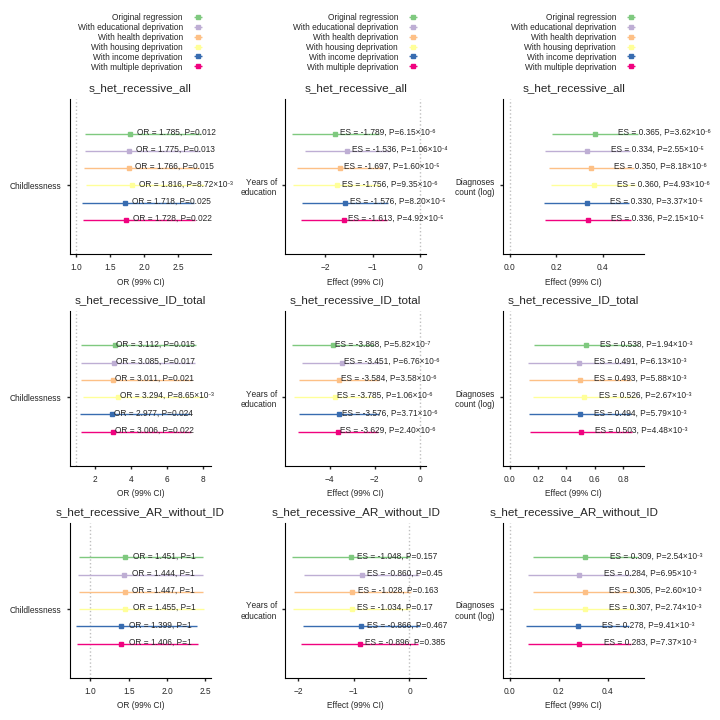

In [ ]:
cm = 1/2.54  # centimeters in inches
k = 1.

fig = plt.figure(constrained_layout=True, figsize=(18*cm*k, 18*cm*k))

all_axes = fig.subplots(3, 3)

for axes, feature in zip(all_axes, ['s_het_recessive_all', 's_het_recessive_ID_total', 's_het_recessive_AR_without_ID']):
    plot_data = deprivation[deprivation['feature'] == feature].copy()

    for idx, target in enumerate(['Childlessness', 'Years of\neducation', 'Diagnoses\ncount (log)']):

        legend_loc = 'upper left' if feature=='s_het_recessive_all' else None
        plot_entity = 'odds_ratio' if target == 'Childlessness' else 'effect'
        plot_deprivation(axes[idx], targets=[target], plot_data=plot_data, legend_loc=legend_loc, plot_entity=plot_entity)
        axes[idx].set_title(feature)

plt.savefig(f"{PLOTS_OUTPUT_DIR}/ext_figure_7.pdf", format="pdf", bbox_inches="tight")

# Extended Figure 8 (ID vs rest)

In [16]:
results_path = f"{tables_folder}/table_id_vs_rest_analysis.xlsx"

# load flat table
id_vs_rest = read_results_excel(results_path, flatten_multiindex=True)

# leave only necessary s_het effect
id_vs_rest = id_vs_rest[id_vs_rest['feature'].str.contains("s_het")]

# add odds ratio distance
id_vs_rest = plotting.add_odds_ratio_intervals(id_vs_rest)
id_vs_rest = plotting.add_effect_size_intervals(id_vs_rest)

In [17]:
# Dictionary to rename target columns
renaming_dict_target = {
    'is_blond': 'Hair color', 
    'years_of_edu': 'Years of\neducation',
    'diagnosis_total_ICD10_cnt_log': 'Diagnoses\ncount (log)',
    'ICD_infertility': 'Infertility',
    'living_with_a_partner': 'Has partner',
    'fluid_intelligence_score': 'Fluid\nintelligence',
    'childlessness': 'Childlessness'
}

# select targets of interest
id_vs_rest = id_vs_rest[id_vs_rest['target'].isin(renaming_dict_target.keys())].copy()
id_vs_rest['target'] = id_vs_rest['target'].apply(lambda x: renaming_dict_target.get(x, x))

# select gender of interest
id_vs_rest = id_vs_rest[id_vs_rest['gender'] == 'all']

# select analyses
renaming_dict_feature = {
    's_het_recessive_AR_without_ID': 'Other recessive genes',
	's_het_recessive_ID_total': 'Recessive ID genes',
}

id_vs_rest = id_vs_rest[id_vs_rest['feature'].isin(renaming_dict_feature.keys())].copy()


id_vs_rest.loc[:, 'analysis'] = id_vs_rest['feature'].apply(lambda x: renaming_dict_feature.get(x, x))


print("Target:", id_vs_rest['target'].unique())

id_vs_rest.head(3)

Target: ['Childlessness' 'Years of\neducation' 'Diagnoses\ncount (log)'
 'Fluid\nintelligence' 'Hair color']


dataset                        feature    effect  odds_ratio  \
0    Cassa  s_het_recessive_AR_without_ID  0.509322    1.664163   
1      pLI  s_het_recessive_AR_without_ID  0.098395    1.103398   
2  Weghorn  s_het_recessive_AR_without_ID  0.578036    1.782534   

   odds_ratio_lower  odds_ratio_upper odds_ratio_pretty   p_value  \
0          0.842551          3.286969        OR = 1.664  0.053920   
1          0.988940          1.231104        OR = 1.103  0.020654   
2          1.010664          3.143902        OR = 1.783  0.008691   

   p_value_corrected  bonferroni_correction_coef  ...  gender  \
0           0.754878                          14  ...     all   
1           0.289152                          14  ...     all   
2           0.121672                          14  ...     all   

                analysis                                            formula  \
0  Other recessive genes  childlessness ~ s_het_recessive_AR_without_ID ...   
1  Other recessive genes  childlessness ~ s_het_recessive_AR_without_ID ...   
2  Other recessive genes  childlessness ~ s_het_recessive_AR_without_ID ...   

     family p_value_pretty p_value_corrected_pretty odds_ratio_lower_distance  \
0  binomial          0.054                    0.755                  0.821612   
1  binomial          0.021                    0.289                  0.114458   
2  binomial      8.69×10⁻³                    0.122                  0.771870   

  odds_ratio_upper_distance  effect_lower_distance  effect_upper_distance  
0                  1.622806               0.680644               0.680644  
1                  0.127705               0.109516               0.109516  
2                  1.361367               0.567429               0.567429  

[3 rows x 22 columns]

In [18]:
def plot_id_vs_rest(ax, dataset, target_order, analysis_order, plot_entity='odds_ratio', vline_loc=1, legend_loc='upper left'):

    legend_kwargs = {
        "bbox_to_anchor": (-0.5, 1.2, 1.2, .102), 
        "frameon": False,
        "mode": "expand", 
        "ncol": 2, 
        "labelspacing": 0.1, 
        "markerfirst": False, 
        'fontsize': plotting.MEDIUM_SIZE
    }

    # colors = ['#151B54','#F5E216']
    colors = [ '#d43d51', '#094074',]
    # colors = [ "#176d8f", "#d43d51"]
    
    plot_data = id_vs_rest[id_vs_rest['target'].isin(target_order)].copy()

    plotted_data = plotting.plot_errorbar_grouped(df=plot_data[plot_data['dataset'] == dataset].copy(), 
                                        axis=ax, 
                                        y_column='target', 
                                        group_column = 'analysis',  
                                        legend_loc=legend_loc, 
                                        legend_kwargs=legend_kwargs,
                                        group_scale=0.25, 
                                        y_scale=0.8,
                                        colors=colors,
                                        group_order=analysis_order, 
                                        plot_entity=plot_entity, 
                                        vertical_loc=vline_loc, 
                                        horizontal=False)
    
    x_label = 'Effect size' if plot_entity == 'effect' else 'Odds ratio'
    
    plotting.configure_axis(ax, x_label=x_label, y_label=None,  format_x=True)

    # Display p-values or any other information in the sidebar
    p_values = plotted_data['p_value_corrected_pretty']
    positions = plotted_data['y']

    plot_loc = plotted_data[f'{plot_entity}'] - plotted_data[f'{plot_entity}_lower_distance']

    for i, (loc, p, pos) in enumerate(zip(plot_loc, p_values, positions)):
        ax.text(loc, pos+0.005, f'P = {p}', va='center', size=plotting.SMALL_SIZE)

def plot_id_vs_rest_subfig(subfig, dataset):

    ticks = ticks_config[dataset]
    xlim = xlim_config[dataset]
    # xlim = None

    axes = subfig.subplots(4, 1)

    analysis_order = ['Recessive ID genes', 'Other recessive genes']

    plot_id_vs_rest(axes[0], dataset=dataset, target_order = ['Childlessness'],
                    analysis_order=analysis_order, plot_entity='odds_ratio', vline_loc=1, legend_loc=None )
    axes[0].set_xlabel(None)
    axes[0].margins(y=0.9)

    plot_id_vs_rest(axes[1], dataset=dataset, target_order = ['Years of\neducation'], 
                    analysis_order=analysis_order, plot_entity='effect', vline_loc=0, legend_loc=None)
    axes[1].set_xlabel(None)
    axes[1].margins(y=0.9)

    plot_id_vs_rest(axes[2], dataset=dataset, target_order = ['Diagnoses\ncount (log)'], 
                    analysis_order=analysis_order, plot_entity='effect', vline_loc=0, legend_loc=None)
    axes[2].set_xlabel(None)
    axes[2].margins(y=0.9)

    plot_id_vs_rest(axes[3], dataset=dataset, target_order = ['Hair color'], 
                    analysis_order=analysis_order, plot_entity='odds_ratio', vline_loc=1, legend_loc=None)
    axes[3].set_xlabel(None)
    axes[3].margins(y=0.9)

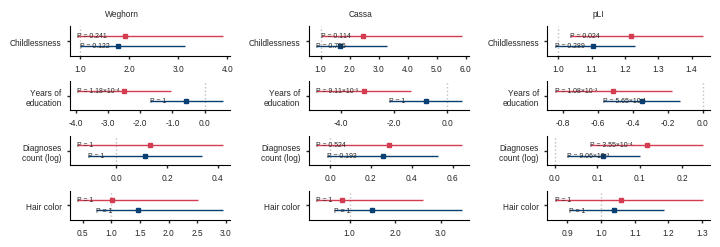

In [19]:
cm = 1/2.54  # centimeters in inches
k = 1.

fig = plt.figure(constrained_layout=True, figsize=(18*cm*k, 6*cm*k))

subfigs = fig.subfigures(nrows=1, ncols=3, width_ratios=[ 1, 1, 1], wspace=0.03)

plot_id_vs_rest_subfig(subfigs[0], 'Weghorn')
subfigs[0].suptitle('Weghorn', fontsize=plotting.MEDIUM_SIZE)

plot_id_vs_rest_subfig(subfigs[1], 'Cassa')
subfigs[1].suptitle('Cassa', fontsize=plotting.MEDIUM_SIZE)

plot_id_vs_rest_subfig(subfigs[2], 'pLI')
subfigs[2].suptitle('pLI', fontsize=plotting.MEDIUM_SIZE)

plt.savefig(f"{PLOTS_OUTPUT_DIR}/ext_figure_8.pdf", format="pdf", bbox_inches="tight")

# Extended figure 9 (synonymous distribution for ID vs rest)

In [ ]:
# Dictionary to rename target columns
renaming_dict_target = {
    'is_blond': 'Hair color', 
    'years_of_edu': 'Years of\neducation',
    'diagnosis_total_ICD10_cnt_log': 'Diagnoses\ncount (log)',
    'ICD_infertility': 'Infertility',
    'living_with_a_partner': 'Has partner',
    'fluid_intelligence_score': 'Fluid\nintelligence',
    'childlessness': 'Childlessness'
}

use_dataset = 'Roulette'

results_path = f"{tables_folder}/table_id_vs_rest_analysis.xlsx"

# load flat table
id_vs_rest = read_results_excel(results_path, flatten_multiindex=True)

# leave only necessary s_het effect
id_vs_rest = id_vs_rest[id_vs_rest['feature'].str.contains("s_het")]

# add odds ratio distance
id_vs_rest = plotting.add_odds_ratio_intervals(id_vs_rest)
id_vs_rest = plotting.add_effect_size_intervals(id_vs_rest)

# filter out dataset
id_vs_rest = id_vs_rest[id_vs_rest['dataset'] == 'Roulette']


# select targets of interest
id_vs_rest = id_vs_rest[id_vs_rest['target'].isin(renaming_dict_target.keys())].copy()
id_vs_rest['target'] = id_vs_rest['target'].apply(lambda x: renaming_dict_target.get(x, x))

# select gender of interest
id_vs_rest = id_vs_rest[id_vs_rest['gender'] == 'all']

# select analyses
renaming_dict_feature = {
    's_het_recessive_AR_without_ID': 'Other recessive genes',
	's_het_recessive_ID_total': 'Recessive ID genes',
}

id_vs_rest = id_vs_rest[id_vs_rest['feature'].isin(renaming_dict_feature.keys())].copy()


id_vs_rest.loc[:, 'analysis'] = id_vs_rest['feature'].apply(lambda x: renaming_dict_feature.get(x, x))


print("Target:", id_vs_rest['target'].unique())

id_vs_rest.head(3)

Target: ['Childlessness' 'Years of\neducation' 'Diagnoses\ncount (log)'
 'Fluid\nintelligence' 'Hair color']


dataset                        feature    effect  odds_ratio  \
3   Roulette  s_het_recessive_AR_without_ID  0.351723    1.421514   
11  Roulette  s_het_recessive_AR_without_ID -1.096313    0.334101   
19  Roulette  s_het_recessive_AR_without_ID  0.261079    1.298330   

    odds_ratio_lower  odds_ratio_upper odds_ratio_pretty   p_value  \
3           0.866127          2.333033        OR = 1.422  0.067458   
11          0.124135          0.899206       ES = -1.096  0.004341   
19          1.066865          1.580012        ES = 0.261  0.000615   

    p_value_corrected  bonferroni_correction_coef  ...  gender  \
3            0.944414                          14  ...     all   
11           0.060778                          14  ...     all   
19           0.008610                          14  ...     all   

                 analysis                                            formula  \
3   Other recessive genes  childlessness ~ s_het_recessive_AR_without_ID ...   
11  Other recessive genes  years_of_edu ~ s_het_recessive_AR_without_ID +...   
19  Other recessive genes  diagnosis_total_ICD10_cnt_log ~ s_het_recessiv...   

      family p_value_pretty p_value_corrected_pretty  \
3   binomial          0.067                    0.944   
11  gaussian      4.34×10⁻³                    0.061   
19  gaussian      6.15×10⁻⁴                8.61×10⁻³   

   odds_ratio_lower_distance odds_ratio_upper_distance  effect_lower_distance  \
3                   0.555387                  0.911519               0.495446   
11                  0.209965                  0.565106               0.990070   
19                  0.231464                  0.281682               0.196354   

    effect_upper_distance  
3                0.495446  
11               0.990070  
19               0.196354  

[3 rows x 22 columns]

In [ ]:
results_path = f"../../../data/tables/sampling/synonymous/table_synonymous_id_vs_rest_analysis.xlsx"

# load flat table
synonymous = read_results_excel(results_path, flatten_multiindex=True)

# leave only necessary s_het effect
synonymous = synonymous[synonymous['feature'].str.contains("s_het")]

# add odds ratio distance
synonymous = plotting.add_odds_ratio_intervals(synonymous)
synonymous = plotting.add_effect_size_intervals(synonymous)

# select targets of interest
synonymous = synonymous[synonymous['target'].isin(renaming_dict_target.keys())].copy()
synonymous['target'] = synonymous['target'].apply(lambda x: renaming_dict_target.get(x, x))

# select gender of interest
synonymous = synonymous[synonymous['gender'] == 'all']

synonymous.head(3)

dataset                        feature    effect  odds_ratio  \
0  Roulette  s_het_recessive_AR_without_ID -0.019862    0.980334   
2  Roulette  s_het_recessive_AR_without_ID  0.011939    1.012010   
4  Roulette  s_het_recessive_AR_without_ID  0.030694    1.031170   

   odds_ratio_lower  odds_ratio_upper odds_ratio_pretty   p_value  \
0          0.748688          1.283652        OR = 0.980  0.849477   
2          0.598617          1.710884        ES = 0.012  0.953297   
4          0.929134          1.144412        ES = 0.031  0.447981   

   p_value_corrected  bonferroni_correction_coef  ...  gender  \
0          11.892676                          14  ...     all   
2          13.346163                          14  ...     all   
4           6.271735                          14  ...     all   

                                            analysis  \
0  synonymous_id_vs_rest regressions on [s_het_re...   
2  synonymous_id_vs_rest regressions on [s_het_re...   
4  synonymous_id_vs_rest regressions on [s_het_re...   

                                             formula    family p_value_pretty  \
0  childlessness ~ s_het_recessive_AR_without_ID ...  binomial          0.849   
2  years_of_edu ~ s_het_recessive_AR_without_ID +...  gaussian          0.953   
4  diagnosis_total_ICD10_cnt_log ~ s_het_recessiv...  gaussian          0.448   

  p_value_corrected_pretty odds_ratio_lower_distance  \
0                        1                  0.231646   
2                        1                  0.413393   
4                        1                  0.102036   

  odds_ratio_upper_distance  effect_lower_distance  effect_upper_distance  
0                  0.303318               0.269571               0.269571  
2                  0.698874               0.525072               0.525072  
4                  0.113242               0.104196               0.104196  

[3 rows x 22 columns]

In [ ]:
def plot_synonymous(ax, targets, synonymous, phenotypes, plot_entity='odds_ratio', vline_loc=1):

    # select necessary targets
    data_syns = synonymous[synonymous['target'].isin(targets)].copy()
    data_plps = phenotypes[phenotypes['target'].isin(targets)].copy()

    # sort dataset according to the target order
    data_syns.target = pd.Categorical(data_syns.target, categories=targets)
    data_syns = data_syns.sort_values('target')

    data_plps.target = pd.Categorical(data_plps.target, categories=targets)
    data_plps = data_plps.sort_values('target')

    # plot neutral line
    ax.vlines(x=vline_loc, ymin=-3, ymax=10, color='grey', linestyle='--', alpha=0.5, linewidth=0.5)
    
    vp = sns.violinplot(data=data_syns, y='target', x=plot_entity, hue='target',
                        ax=ax, linewidth=0.5, linecolor='k', palette=['#a0b4ff'])

    # plot PLPs estimation
    pp = sns.pointplot(data=data_plps, y='target', x=plot_entity, linestyle='none', markers='o', 
                       ax=ax, color='#ffa260', markersize=3, markeredgewidth=0.5, markeredgecolor='k')

/tmp/ipykernel_303/1512117598.py:17: UserWarning: 
The palette list has fewer values (1) than needed (5) and will cycle, which may produce an uninterpretable plot.
  vp = sns.violinplot(data=data_syns, y='target', x=plot_entity, hue='target',
/tmp/ipykernel_303/1512117598.py:17: UserWarning: 
The palette list has fewer values (1) than needed (5) and will cycle, which may produce an uninterpretable plot.
  vp = sns.violinplot(data=data_syns, y='target', x=plot_entity, hue='target',


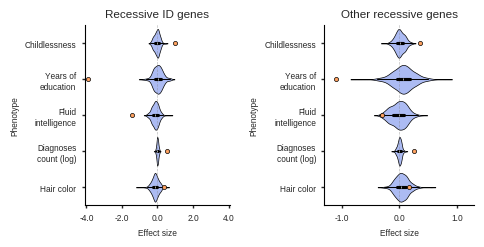

In [ ]:
import matplotlib.ticker as ticker

cm = 1/2.54  # centimeters in inches
k = 1.
fig = plt.figure(constrained_layout=True, figsize=(12*cm*k, 6*cm*k))

# divide subfigure into left and right parts
subfigs = fig.subfigures(nrows=1, ncols=2, width_ratios=[1, 1], wspace=0.03)

targets = ['Childlessness', 'Years of\neducation', 'Fluid\nintelligence', 'Diagnoses\ncount (log)',  'Hair color']

# plot phenotypes results
ax_left = subfigs[0].subplots(1, 1)


plot_synonymous(ax_left, synonymous=synonymous[synonymous['feature'] == 's_het_recessive_ID_total'], 
                phenotypes=id_vs_rest[id_vs_rest['feature'] == 's_het_recessive_ID_total'], 
                targets=targets, plot_entity='effect', vline_loc=0)

ax_left.set_title('Recessive ID genes')
plotting.configure_axis(ax_left, x_label='Effect size', y_label='Phenotype', xlim=(-4.1, 4.1), ymargin=0.02, format_x=True)


# plot synonymous
ax_right = subfigs[1].subplots(1, 1)


plot_synonymous(ax_right, synonymous=synonymous[synonymous['feature'] == 's_het_recessive_AR_without_ID'], 
                phenotypes=id_vs_rest[id_vs_rest['feature'] == 's_het_recessive_AR_without_ID'], 
                targets=targets, plot_entity='effect', vline_loc=0)
ax_right.set_title('Other recessive genes')

plotting.configure_axis(ax_right, x_label='Effect size', y_label='Phenotype', xlim=(-1.3, 1.3), ymargin=0.02, format_x=True)

# save figure
plt.savefig(f"{PLOTS_OUTPUT_DIR}/ext_figure_9.pdf", format="pdf", bbox_inches="tight")

# Extended figure 10 (s-het distribution over panels)

In [31]:
# read original gene panel

gene_panels = pd.read_csv(".../450k/regions/gene-panel-gencode-v34.txt", header=None)
gene_panels.columns = ['gene_symbol', 'panel']

print ("Number of genes:", gene_panels.shape[0])

Number of genes: 1929


In [32]:
show_order = [
    'Non-Recessive',
    'All recessive',
    'ID',
    'Metabolic',
    'Metabolic-ID',
    'Dermatologic',
    'Blindness',
    'Multi-system',
    'Neuromuscular',
    'Cilia + Kidney',
    'Immune system',
    'Endocrine',
    'Skeletal',
    'Hematologic',
    'Deafness'
]


s_het = pd.read_csv(".../450k/selection_roulette/s_het_roulette_gencode-v34.csv", sep='\t')

s_het = s_het.merge(gene_panels, how='left').rename(columns={'panel': 'Gene set'})

s_het['Gene set'] = s_het['Gene set'].fillna('Non-Recessive')

renaming_dict_gene_sets = {
	'Cilia+Kidney': 'Cilia + Kidney',
     'Derm': 'Dermatologic',
	'ID-total': 'ID',
	'Immune_system': 'Immune system',
	'Overlaps': 'Multi-system',
	'Skeletal+Craniofacial': 'Skeletal'
}

delete_list = ['No_panel', 'Tumor', 'Cardiovascular']

s_het['Gene set'] = s_het['Gene set'].apply(lambda x: renaming_dict_gene_sets.get(x, x))
s_het = s_het[~s_het['Gene set'].isin(delete_list)]

s_het_recessive = s_het[s_het['Gene set'] != 'Non-Recessive'].copy()
s_het_recessive['Gene set'] = 'All recessive'

s_het = pd.concat([s_het, s_het_recessive])

s_het['Gene set'] = s_het['Gene set'].astype('category')
s_het['Gene set'] = s_het['Gene set'].cat.set_categories(show_order, ordered=True)

s_het = s_het.sort_values(by='Gene set')

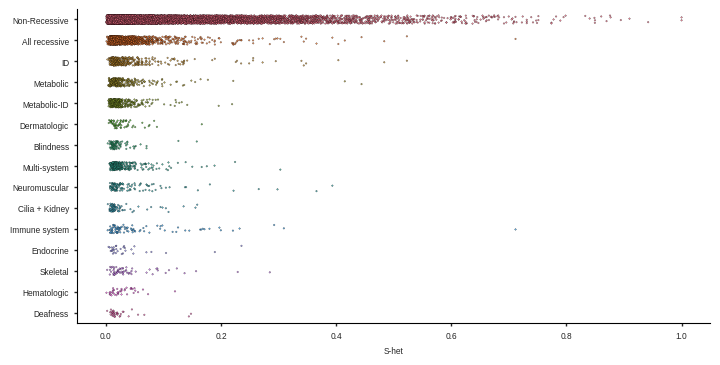

In [33]:
cm = 1/2.54  # centimeters in inches
k = 1.

fig = plt.figure(constrained_layout=True, figsize=(18*cm*k, 9*cm*k))

ax = fig.subplots(1, 1)

sns.stripplot(data=s_het, x='s_het', y='Gene set', hue='Gene set', 
              jitter=0.2, edgecolor='black', size=1,
              marker="D", linewidth=0.2, alpha=.8, ax=ax)

# plt.axvline(x=0.1,  linestyle='--', color='gray', linewidth=1)

plotting.configure_axis(ax, x_label='S-het', y_label=None, ymargin=0)

plt.savefig(f"{PLOTS_OUTPUT_DIR}/ext_figure_10.pdf", format="pdf", bbox_inches="tight")

# Extended figure 11 (distribution non-ID gene panel)

In [57]:
renaming_dict_gene_sets = {f"AR_without_ID_{i}_sampled": f"Other recessive genes (sample {i+1})" for i in range (0, 20)}
renaming_dict_gene_sets['ID_sampled'] = 'ID'

s_het = pd.read_csv(".../450k/selection_roulette/s_het_roulette_gencode-v34.csv", sep='\t')
s_het = s_het.rename(columns={'gene_symbol': 'Gene name'})

gene_panel_sampled = pd.read_csv(".../450k/regions/gene-panel-gencode-v34.sampled.txt")

gene_panel_sampled = gene_panel_sampled.merge(s_het, how='left')

gene_panel_sampled['Gene panel'] = gene_panel_sampled['Gene panel'].apply(lambda x: renaming_dict_gene_sets.get(x, x))

gene_panel_sampled

Gene name                         Gene panel     s_het
0        ROGDI                                 ID  0.015856
1          IYD                                 ID  0.021400
2        FREM2                                 ID  0.032609
3         BBS2                                 ID  0.010166
4        AMPD2                                 ID  0.025070
...        ...                                ...       ...
7451     PRKDC  Other recessive genes (sample 16)  0.711598
7452     PRKDC  Other recessive genes (sample 17)  0.711598
7453     PRKDC  Other recessive genes (sample 18)  0.711598
7454     PRKDC  Other recessive genes (sample 19)  0.711598
7455     PRKDC  Other recessive genes (sample 20)  0.711598

[7456 rows x 3 columns]

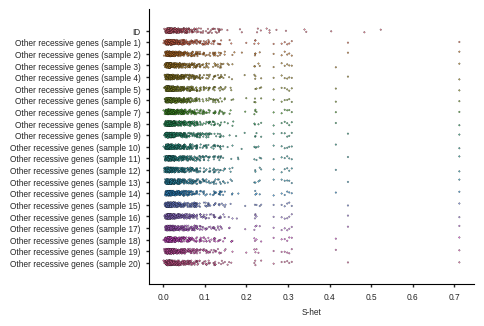

In [58]:
import matplotlib.ticker as ticker

cm = 1/2.54  # centimeters in inches
k = 1.
fig = plt.figure(constrained_layout=True, figsize=(12*cm*k, 8*cm*k))

ax = fig.subplots(1, 1)
sns.stripplot(data=gene_panel_sampled, x='s_het', y='Gene panel', hue='Gene panel', 
              jitter=0.2, edgecolor='black', size=1,
              marker="D", linewidth=0.2, alpha=.8, ax=ax)
plotting.configure_axis(ax, x_label='S-het', xlim=None, ymargin=0.08, format_x=True)

# save figure
plt.savefig(f"{PLOTS_OUTPUT_DIR}/ext_figure_11.pdf", format="pdf", bbox_inches="tight")

# Extended figure 12 (resampling non-ID gene panel)

In [40]:
# Dictionary to rename target columns
renaming_dict_target = {
    'is_blond': 'Hair color', 
    'years_of_edu': 'Years of\neducation',
    'diagnosis_total_ICD10_cnt_log': 'Diagnoses\ncount (log)',
    'ICD_infertility': 'Infertility',
    'living_with_a_partner': 'Has partner',
    'fluid_intelligence_score': 'Fluid\nintelligence',
    'childlessness': 'Childlessness'
}

tables_folder = '../../../data/tables'

sampling_df = read_results_excel(f"{tables_folder}/sampling/genes/table_id_vs_other_sampling_analysis.xlsx", 
                                 flatten_multiindex=True)

# leave only necessary s_het effect
sampling_df = sampling_df[sampling_df['feature'].str.contains("s_het")]

# add odds ratio distance
sampling_df = plotting.add_odds_ratio_intervals(sampling_df)
sampling_df = plotting.add_effect_size_intervals(sampling_df)

# rename target
sampling_df = sampling_df[sampling_df['target'].isin(renaming_dict_target.keys())].copy()
sampling_df['target'] = sampling_df['target'].apply(lambda x: renaming_dict_target.get(x, x))


In [41]:
def plot_sampling(ax, targets, plot_entity='odds_ratio', vline_loc=1):

    # select necessary targets
    data_non_id = sampling_df[sampling_df['target'].isin(targets) & (sampling_df['feature'] != 's_het_recessive_ID_sampled')].copy()
    data_id = sampling_df[sampling_df['target'].isin(targets) & (sampling_df['feature'] == 's_het_recessive_ID_sampled')].copy()

    # sort dataset according to the target order
    data_non_id.target = pd.Categorical(data_non_id.target, categories=targets)
    data_non_id = data_non_id.sort_values('target')

    data_id.target = pd.Categorical(data_id.target, categories=targets)
    data_id = data_id.sort_values('target')

    # plot neutral line
    ax.vlines(x=vline_loc, ymin=-3, ymax=10, color='grey', linestyle='--', alpha=0.5, linewidth=0.5)
    
    vp = sns.violinplot(data=data_non_id[data_non_id['gender'] == 'all'], y='target', x=plot_entity, hue='target',
                ax=ax, linewidth=0.5, linecolor='k', palette=['#a0b4ff'])

    # plot PLPs estimation
    pp = sns.pointplot(data=data_id[data_id['gender'] == 'all'], y='target', x=plot_entity,
                    linestyle='none', markers='o', ax=ax, color='#ffa260', markersize=3, markeredgewidth=0.5, markeredgecolor='k')

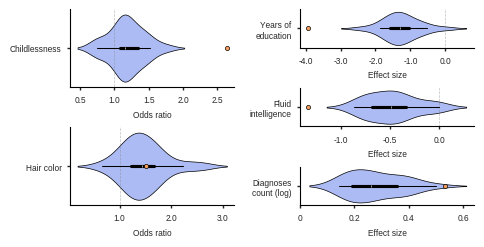

In [42]:
import matplotlib.ticker as ticker

cm = 1/2.54  # centimeters in inches
k = 1.
fig = plt.figure(constrained_layout=True, figsize=(12*cm*k, 6*cm*k))

# divide subfigure into left and right parts
subfigs = fig.subfigures(nrows=1, ncols=2,  width_ratios=[1, 1], wspace=0.03)

# plot phenotypes results
ax_left = subfigs[0].subplots(2, 1)
plot_sampling(ax_left[0], targets = ['Childlessness'], plot_entity='odds_ratio', vline_loc=1)
plot_sampling(ax_left[1], targets = ['Hair color'], plot_entity='odds_ratio', vline_loc=1)

plotting.configure_axis(ax_left[0], x_label='Odds ratio',  xlim=None, ymargin=0.08, format_x=True)
plotting.configure_axis(ax_left[1], x_label='Odds ratio', xlim=None, ymargin=0.08, format_x=True)


# plot synonymous
ax_right = subfigs[1].subplots(3, 1)

plot_sampling(ax_right[0], targets = ['Years of\neducation'], plot_entity='effect', vline_loc=0)

plot_sampling(ax_right[1], targets = ['Fluid\nintelligence'], plot_entity='effect', vline_loc=0)

plot_sampling(ax_right[2], targets = ['Diagnoses\ncount (log)'], plot_entity='effect', vline_loc=0)

plotting.configure_axis(ax_right[0], x_label='Effect size', xlim=None, ymargin=0.08, format_x=True)
plotting.configure_axis(ax_right[1], x_label='Effect size', xlim=None, ymargin=0.08, format_x=True)
plotting.configure_axis(ax_right[2], x_label='Effect size',  xlim=None, ymargin=0.08, format_x=True)
ax_right[2].set_xticks([0, 0.2, 0.4, 0.6])
ax_right[2].set_xticklabels([0, 0.2, 0.4, 0.6])

# save figure
plt.savefig(f"{PLOTS_OUTPUT_DIR}/ext_figure_12.pdf", format="pdf", bbox_inches="tight")

# Extended figure 13 (sex-speific)

In [59]:
# Dictionary to rename target columns
renaming_dict_target = {
    'is_blond': 'Hair color', 
    'years_of_edu': 'Years of\neducation',
    'diagnosis_total_ICD10_cnt_log': 'Diagnoses\ncount (log)',
    'ICD_infertility': 'Infertility',
    'living_with_a_partner': 'Has partner',
    'fluid_intelligence_score': 'Fluid\nintelligence',
    'childlessness': 'Childlessness'
}

results_path = f"{tables_folder}/table_sex_specific_analysis.xlsx"

# load flat table
sex_specific = read_results_excel(results_path, flatten_multiindex=True)

# leave only necessary s_het effect
sex_specific = sex_specific[sex_specific['feature'].str.contains("s_het")]

# add odds ratio distance
sex_specific = plotting.add_odds_ratio_intervals(sex_specific)
sex_specific = plotting.add_effect_size_intervals(sex_specific)

# select dataset
sex_specific = sex_specific[sex_specific['dataset'] == 'Roulette']
sex_specific['target'] = sex_specific['target'].apply(lambda x: renaming_dict_target.get(x, x))
sex_specific = sex_specific[sex_specific['analysis'] == 'basic_analysis']


In [62]:
def plot_sex_specific(ax, dataset, targets, gender_order=['males', 'females'], 
                      plot_entity='odds_ratio', vline_loc=1, legend_loc='upper left'):

    legend_kwargs = {
        "bbox_to_anchor": (-0.5, 1.2, 1.2, .102), 
        "frameon": False,
        "mode": "expand", 
        "ncol": 2, 
        "labelspacing": 0.1, 
        "markerfirst": False, 
        'fontsize': plotting.MEDIUM_SIZE
    }

    colors = [ '#d43d51', '#094074',]
    
    plot_data = dataset[dataset['target'].isin(targets)].copy()

    plotted_data = plotting.plot_errorbar_grouped(df=plot_data, 
                                        axis=ax, 
                                        y_column='target', 
                                        group_column = 'gender',  
                                        legend_loc=legend_loc, 
                                        legend_kwargs=legend_kwargs,
                                        group_scale=0.25, 
                                        y_scale=0.8,
                                        colors=colors,
                                        group_order=gender_order, 
                                        plot_entity=plot_entity, 
                                        vertical_loc=vline_loc, 
                                        horizontal=False)
    
    x_label = 'Effect size' if plot_entity == 'effect' else 'Odds ratio'
    
    plotting.configure_axis(ax, x_label=x_label, y_label=None,  format_x=True)

    # Display p-values or any other information in the sidebar
    odds_ratios = plotted_data[f'odds_ratio_pretty']
    p_values = plotted_data['p_value_corrected_pretty']
    positions = plotted_data['y']

    plot_loc = plotted_data[f'{plot_entity}'] - plotted_data[f'{plot_entity}_lower_distance']

    for i, (loc, eff, p, pos) in enumerate(zip(plot_loc, odds_ratios, p_values, positions)):
        ax.text(loc+0.1, pos+0.005, f'{eff}, P = {p}', va='center', size=plotting.SMALL_SIZE)

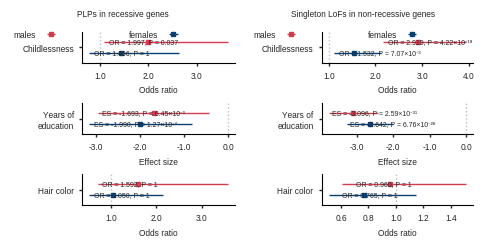

In [63]:
import matplotlib.ticker as ticker

cm = 1/2.54  # centimeters in inches
k = 1.
fig = plt.figure(constrained_layout=True, figsize=(12*cm*k, 6*cm*k))

# divide subfigure into left and right parts
subfigs = fig.subfigures(nrows=1, ncols=2,  width_ratios=[1, 1], wspace=0.03)

# plot phenotypes results
ax_left = subfigs[0].subplots(3, 1)
df = sex_specific[sex_specific['feature'] == 's_het_recessive_all'].copy()
plot_sex_specific(ax_left[0], dataset=df, targets = ['Childlessness'], plot_entity='odds_ratio', vline_loc=1)
plot_sex_specific(ax_left[1], dataset=df, targets = ['Years of\neducation'], plot_entity='effect', vline_loc=0, legend_loc=None)
plot_sex_specific(ax_left[2], dataset=df, targets = ['Hair color'], plot_entity='odds_ratio', vline_loc=1, legend_loc=None)

plotting.configure_axis(ax_left[0], x_label='Odds ratio',  xlim=None, ymargin=0.9, format_x=True)
plotting.configure_axis(ax_left[1], x_label='Effect size', xlim=None, ymargin=0.9, format_x=True)
plotting.configure_axis(ax_left[2], x_label='Odds ratio', xlim=None, ymargin=0.9, format_x=True)
subfigs[0].suptitle('PLPs in recessive genes', size=plotting.MEDIUM_SIZE)

# plot synonymous
ax_right = subfigs[1].subplots(3, 1)
df = sex_specific[sex_specific['feature'] == 's_het_lof_without_AR'].copy()
plot_sex_specific(ax_right[0], dataset=df, targets = ['Childlessness'], plot_entity='odds_ratio', vline_loc=1)
plot_sex_specific(ax_right[1], dataset=df, targets = ['Years of\neducation'], plot_entity='effect', vline_loc=0, legend_loc=None)
plot_sex_specific(ax_right[2], dataset=df, targets = ['Hair color'], plot_entity='odds_ratio', vline_loc=1, legend_loc=None)

plotting.configure_axis(ax_right[0], x_label='Odds ratio',  xlim=None, ymargin=0.9, format_x=True)
plotting.configure_axis(ax_right[1], x_label='Effect size', xlim=None, ymargin=0.9, format_x=True)
plotting.configure_axis(ax_right[2], x_label='Odds ratio', xlim=None, ymargin=0.9, format_x=True)
subfigs[1].suptitle('Singleton LoFs in non-recessive genes', size=plotting.MEDIUM_SIZE)

# save figure
plt.savefig(f"{PLOTS_OUTPUT_DIR}/ext_figure_13.pdf", format="pdf", bbox_inches="tight")

# Extended figure 14 (CRs)

In [46]:
renaming_dict_gene_sets = {
    'ID-total': 'ID',
    'Skeletal+Craniofacial': 'Skeletal',
    'Derm': 'Dermatologic',
    'Overlaps': 'Multi-system', 
    'Immune_system': 'Immune system',
}

ukb_cr_df = pd.read_csv(f"{tables_folder}/CR.csv", sep='\t').rename(columns={'panel': 'Panel', 'CR': 'Consaguinity ratio'})
ukb_cr_df['Cohort'] = 'UKB'

ukb_cr_df = ukb_cr_df[['Panel', 'Cohort', 'Consaguinity ratio']]
ukb_cr_df['Consaguinity ratio'] = ukb_cr_df['Consaguinity ratio'].astype(int)
ukb_cr_df['Panel'] = ukb_cr_df['Panel'].apply(lambda x: renaming_dict_gene_sets.get(x, x))
ukb_cr_df

Panel Cohort  Consaguinity ratio
0     Hematologic    UKB                 123
1   Neuromuscular    UKB                  77
2              ID    UKB                  66
3        Skeletal    UKB                  60
4    Cilia+Kidney    UKB                  41
5    Metabolic-ID    UKB                  33
6    Dermatologic    UKB                  33
7    Multi-system    UKB                  28
8       Blindness    UKB                  28
9   Immune system    UKB                  20
10      Endocrine    UKB                  18
11       Deafness    UKB                  15
12      Metabolic    UKB                   9

In [47]:
cr_df = pd.read_csv(f"{tables_folder}/CR_dutch_estonian.csv").melt(id_vars='Panel', value_vars=['UKB', 'Dutch', 'Estonian']).rename(
    columns={'variable': 'Cohort', 'value': 'Consaguinity ratio'})

cr_df = cr_df[cr_df['Panel'] != 'Severe genes']
cr_df = pd.concat([ ukb_cr_df, cr_df[cr_df['Cohort'] != 'UKB'],])
cr_df = cr_df.sort_values(by='Consaguinity ratio', ascending=False)
cr_df.head(3)

Panel    Cohort  Consaguinity ratio
0   Hematologic       UKB                 123
15     Skeletal     Dutch                 123
30     Skeletal  Estonian                  92

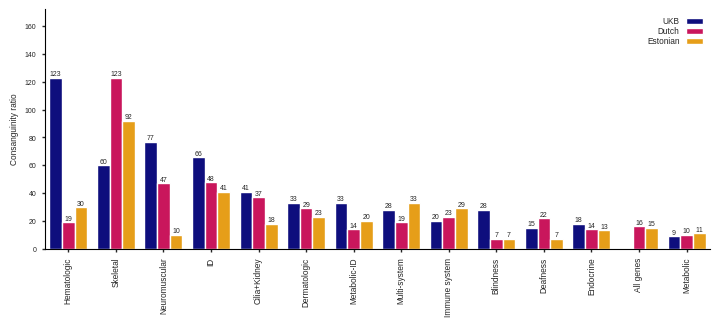

In [48]:
cm = 1/2.54  # centimeters in inches
k = 1.

fig = plt.figure(constrained_layout=True, figsize=(18*cm*k, 8*cm*k))

ax = fig.subplots(1, 1)

colors = ['#00008b', '#df0057', '#ffa600']

sns.barplot(data=cr_df, x='Panel', y='Consaguinity ratio', hue='Cohort', ax=ax, palette=colors, saturation=0.8)

for container in ax.containers:
    ax.bar_label(container, size=plotting.SMALL_SIZE)

# ax.grid(linestyle='dotted', axis='y') 
plotting.configure_axis(ax, x_label=None, y_label='Consanguinity ratio', ytick_size=plotting.SMALL_SIZE)

plt.xticks(rotation=90)
plt.xlabel(None)

legend_kwargs = {
        "frameon": False,
        "labelspacing": 0.1, 
        "markerfirst": False, 
        'fontsize': plotting.MEDIUM_SIZE
    }

plt.legend(**legend_kwargs)

# save figure
plt.savefig(f"{PLOTS_OUTPUT_DIR}/ext_figure_14.pdf", format="pdf", bbox_inches="tight")

# Extended figure 15 (UKB-Dutch CR correlation)

In [49]:
# read dutch AF
dutch_af = pd.read_csv(f"{tables_folder}/dutch_cohort_average_af.csv")
dutch_af['panel'] = dutch_af['Gene set'].apply(lambda x: x.split()[0])
dutch_af = dutch_af.rename(columns={'Average AF Dutch cohort': 'Dutch cohort AF'})[['panel', 'Dutch cohort AF']]

dutch_af.head(2)

panel  Dutch cohort AF
0     Skeletal         0.000157
1  Hematologic         0.000591

In [50]:
renaming_dict_gene_sets = {
    'Derm': 'Dermatologic',
	'ID-total': 'ID',
	'Immune_system': 'Immune',
	'Overlaps': 'Multi-system',
	'Skeletal+Craniofacial': 'Skeletal'
}

n_samples = 378751

# gene panel
gene_panel = pd.read_csv(".../450k/regions/gene-panel-gencode-v34.txt", header=None)
gene_panel.columns = ['gene', 'panel']

# read plps
plps = ".../450k/plp_selection/basic/new_gene_names/new_freq/new_relatedness/all_chr_total_presumable_plps_HFE_final_sorted.txt"

plps = pd.read_csv(plps, sep='\t')

# merhe with gene panel info
plps = plps.merge(gene_panel, how='inner', on='gene')
plps['panel'] = plps['panel'].apply(lambda x: renaming_dict_gene_sets.get(x, x))

# average over gene
ukbb_af = plps.groupby(['panel', 'gene'])[['hets', 'homs']].sum().reset_index()
ukbb_af['UK Biobank AF'] = (ukbb_af['hets'] + 2*ukbb_af['homs']) / (2*n_samples)

# average over panel
ukbb_af = ukbb_af.groupby('panel')['UK Biobank AF'].mean().reset_index()
ukbb_af.head(2)

panel  UK Biobank AF
0       Blindness       0.000498
1  Cardiovascular       0.000451

In [51]:
af_df = ukbb_af.merge(dutch_af, how='inner',)

af_df

panel  UK Biobank AF  Dutch cohort AF
0       Blindness       0.000498         0.000518
1    Cilia+Kidney       0.000487         0.000541
2        Deafness       0.000971         0.000910
3    Dermatologic       0.000453         0.000557
4       Endocrine       0.000587         0.000533
5     Hematologic       0.000257         0.000591
6              ID       0.000355         0.000398
7          Immune       0.000384         0.000297
8       Metabolic       0.000885         0.000646
9    Metabolic-ID       0.000447         0.000594
10   Multi-system       0.000521         0.000556
11  Neuromuscular       0.000279         0.000380
12       Skeletal       0.000216         0.000157

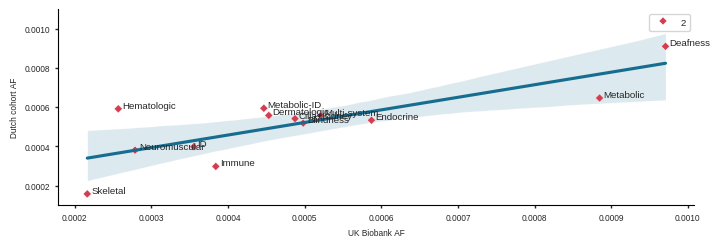

In [52]:
import matplotlib.ticker as ticker

cm = 1/2.54  # centimeters in inches
k = 1.

fig = plt.figure(constrained_layout=True, figsize=(18*cm*k, 6*cm*k))
ax = fig.subplots(1, 1)

colors = [ "#de6069", "#49829f"]


sns.regplot(data=af_df, x='UK Biobank AF', y='Dutch cohort AF', marker='D',  scatter_kws={"color": "#d43d51", 's':2}, color="#176d8f", ax=ax)

sns.scatterplot(data=af_df, x='UK Biobank AF', y='Dutch cohort AF', marker='D', size=2, color='#d43d51', ax=ax)

# sns.lineplot(x=[0, 0.001], y=[0, 0.001], color='gray', linestyle='--')
for row in af_df.values:
    gene_set, ukb_af, dutch_af = tuple(row)
    plt.annotate(gene_set, (ukb_af+0.000005,  dutch_af+0.000005))

plotting.configure_axis(ax, x_label='UK Biobank AF', y_label='Dutch cohort AF', format_x=False, format_y=False, ylim=[0.0001, 0.0011])

# save figure
plt.savefig(f"{PLOTS_OUTPUT_DIR}/ext_figure_15.pdf", format="pdf", bbox_inches="tight")

In [53]:
from scipy.stats import pearsonr

corr_coefficient, p_value = pearsonr(af_df['UK Biobank AF'].values, af_df['Dutch cohort AF'].values)

corr_coefficient, p_value 

(np.float64(0.7908218733021452), np.float64(0.0012870426944499036))

In [55]:
!ls -lah $PLOTS_OUTPUT_DIR

total 2.7M
drwxrwx--- 2 gelana bioinf  523 Aug 30 11:49 .
drwxrwx--- 3 gelana bioinf  400 Aug 30 17:10 ..
-rwxrwx--- 1 gelana bioinf  21K Sep  4 15:01 ext_figure_10.pdf
-rwxrwx--- 1 gelana bioinf  12K Sep  4 15:01 ext_figure_11.pdf
-rwxrwx--- 1 gelana bioinf  13K Sep  4 15:01 ext_figure_12.pdf
-rwxrwx--- 1 gelana bioinf  15K Sep  4 15:01 ext_figure_13.pdf
-rwxrwx--- 1 gelana bioinf  12K Sep  4 15:01 ext_figure_1.pdf
-rwxrwx--- 1 gelana bioinf  11K Sep  4 15:01 ext_figure_2.pdf
-rwxrwx--- 1 gelana bioinf  14K Sep  4 15:01 ext_figure_3.pdf
-rwxrwx--- 1 gelana bioinf  15K Sep  4 15:01 ext_figure_4.pdf
-rwxrwx--- 1 gelana bioinf  14K Sep  4 15:01 ext_figure_5.pdf
-rwxrwx--- 1 gelana bioinf  14K Sep  4 15:01 ext_figure_6.pdf
-rwxrwx--- 1 gelana bioinf  13K Sep  4 15:01 ext_figure_7.pdf
-rwxrwx--- 1 gelana bioinf 289K Sep  4 15:01 ext_figure_8.pdf
-rwxrwx--- 1 gelana bioinf 121K Sep  4 15:01 ext_figure_9.pdf
-rwxrwx--- 1 gelana bioinf  19K Sep  4 15:01 ext_figure_X.pdf
-rwxrwx--- 1 gelana bi